In [1]:
import os
import torch
import numpy as np
from emcee import EnsembleSampler
from src.flow import NormFlow
from getdist import plots, MCSamples
import getdist
import matplotlib.pylab as plt 
from typing import Any 
import dill 
import pandas as pd 

plt.rc("text", usetex=True)
plt.rc("font", **{"family": "sans-serif", "serif": ["Palatino"]})
FONTSIZE = 20

In [2]:
COLS_tau = ['sigma8', 'Omega_cdm', 'Omega_b', 'h', 'n_s', 'tau'] 

# Processing

In [3]:
def process_oxford_tau_planck_2018(save=False, burnin=None, thin = None):
    fname = 'P18_lcdm_nu'
    columns = [30, 3, 4, 5, 6, 7]
    record = []
    for i in range(6):
        samples = np.loadtxt(f'originalsamples/{fname}/{fname}.{i+1}.txt')
        cosmologies = samples[:,columns]
        if burnin is not None:
            start = int(cosmologies.shape[0] * burnin)
            cosmologies = cosmologies[start:]
        if thin is not None:
            cosmologies = cosmologies[0::thin]
        record.append(cosmologies)
    record = np.concatenate(record)
    df = pd.DataFrame(record, columns=COLS_tau)
    print(f'Total number of samples for Oxford Planck 2018 is: {df.shape[0]}')
    if save:
        df.to_csv(f'samples/{fname}_tau.csv')
    return df

In [4]:
training_points = process_oxford_tau_planck_2018(save=False, burnin=0.25)

Total number of samples for Oxford Planck 2018 is: 34828


# Training

In [5]:
def triangle_cosmology(
    samples1: np.ndarray, samples2: np.ndarray, label1: str, label2: str, fname: str = None
):
    """Creates a triangle plot given the original samples and the flow samples.

    Args:
        samples1 (np.ndarray): the original samples
        samples2 (np.ndarray): the flow samples
        label1 (str): label for the first set of samples
        label2 (str): label for the second set of samples
        fname (str): name of the file for output
    """

    settings = {
        "mult_bias_correction_order": 0,
        "smooth_scale_2D": 0.3,
        "smooth_scale_1D": 0.3,
    }
    color2 = "#50C878"
    color1 = "#222E50"

    ndim = 6
    names = ["x%s" % i for i in range(ndim)]
    labels = [r"$\sigma_{8}$", r"$\Omega_{c}$", r"$\Omega_{b}$", r"$h$", r"$n_{s}$", r"$\tau$"]

    samples_1 = MCSamples(
        samples=samples1, names=names, labels=labels, label=label1, settings=settings
    )
    samples_2 = MCSamples(
        samples=samples2, names=names, labels=labels, label=label2, settings=settings
    )

    G = plots.getSubplotPlotter(subplot_size=1.0)
    G.settings.solid_contour_palefactor = 0.9
    G.settings.alpha_filled_add = 0.9
    G.settings.num_plot_contours = 2
    G.settings.lw_contour = 1
    G.settings.axes_fontsize = 15
    G.settings.lab_fontsize = 15
    G.settings.fontsize = 35
    G.settings.legend_fontsize = 14
    samples_1.updateSettings({"contours": [0.68, 0.95]})
    samples_2.updateSettings({"contours": [0.68, 0.95]})
    G.triangle_plot(
        [samples_2, samples_1],
        filled=[True, False],
        contour_colors=[color2, color1],
        contour_lws=[2, 2],
        contour_ls=["-", "-"],
        legend_loc=(0.45, 0.88),
    )
    plt.show()

In [6]:
# fname = 'P18_lcdm_nu_tau'
# flow_folder = 'flows'
# flow = NormFlow(fname, 25000)
# loss = flow.training(lr=1E-3, nsteps=3000)
# torch.save(flow, f"{flow_folder}/{fname}.pt")

# flow_samples = flow.generate_samples(50000)
# triangle_cosmology(testing.values, flow_samples, 'Planck', 'Planck (flow)')

# Sampling 

In [21]:
def load_flow(experiment: str) -> NormFlow:
    """Load a pre-trained normalising flow.

    Args:
        experiment (str): name of the experiment (flow)

    Returns:
        NormFlow: the pre-trained normalising flow
    """
    flow = torch.load(f"flows/{experiment}.pt")
    return flow


def loglike_flows(sample, flows):

    keys = list(flows.keys())
    logl = 0.0
    for key in keys:
        if 'P18' in key:
            logl += flows[key].loglike(sample).item()
        else:
            logl += flows[key].loglike(sample[0:5]).item()
    return logl

def loglike_flow_planck(sample, flow):
    return flow.loglike(sample).item()

In [8]:
fname_1 = 'P18_lcdm_nu_tau'
fname_2 = 'FD_Garcia-Garcia2021_dzMarg_mMarg_nu'
flows = {fname_1: load_flow(fname_1), fname_2: load_flow(fname_2)}

Removed no burn in
Removed no burn in


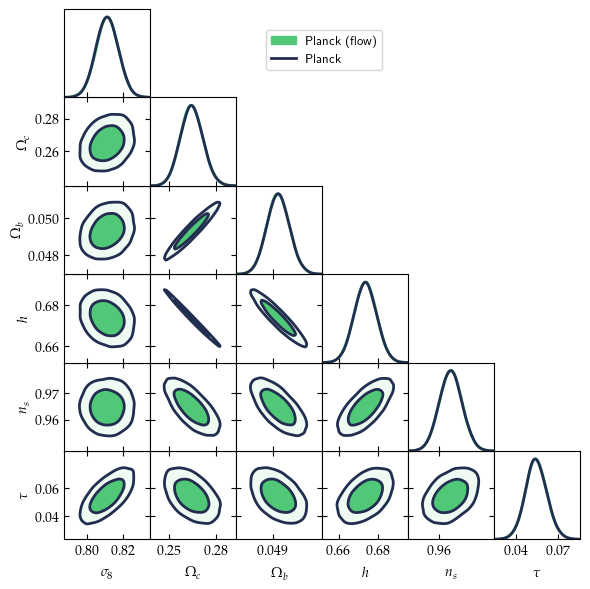

In [11]:
triangle_cosmology(training_points.values, flows[fname_1].generate_samples(50000), 'Planck', 'Planck (flow)')

This is just a check using the log-density of the flow.

In [22]:
class SampleFlowPlanck:
    """Draw samples from the joint, given a list of experiments.

    Args:
        experiments (list): a list of experiments we want to use.
    """

    def __init__(self, flow):

        self.flow = flow
        self.mean = self.flow.samples.mean(0)
        self.ndim = len(self.mean)
        self.nwalkers = 2 * self.ndim

    def sampler(self, nsamples: int, eps: float) -> EnsembleSampler:
        """Sample the joint using emcee.

        Args:
            nsamples (int): the number of samples we want
            eps (float): the step-size to use in emcee.

        Returns:
            EnsembleSampler: the emcee Ensemble sampler
        """
        pos = self.mean + eps * np.random.randn(self.nwalkers, self.ndim)
        sampler = EnsembleSampler(
            self.nwalkers, self.ndim, loglike_flow_planck, args=(self.flow,)
        )
        sampler.run_mcmc(pos, nsamples, progress=True)
        return sampler

In [23]:
# testing = SampleFlowPlanck(flows['P18_lcdm_nu_tau'])
# sampler = testing.sampler(10000, 1e-3)

Removed no burn in
Removed no burn in


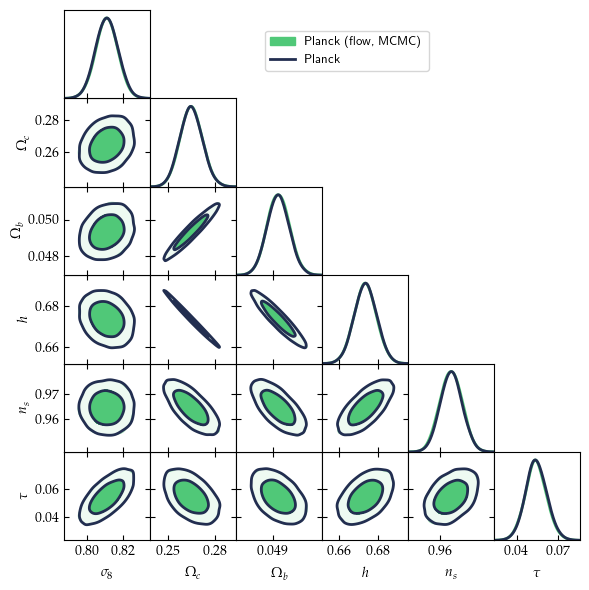

In [27]:
triangle_cosmology(training_points.values, sampler.flatchain, 'Planck', 'Planck (flow, MCMC)')

In [9]:
# cosmology = np.array([0.811, 0.264, 0.049, 0.673, 0.964, 0.054])
cosmology = np.array([0.80297535,  0.26156982, 0.048725855, 0.67584377, 0.96929593, 0.041216335])

In [10]:
flows[fname_1].loglike(cosmology).item()

25.86345100402832

In [63]:
flows[fname_2].loglike(cosmology[0:5]).item()

-4.281316757202148

In [59]:
loglike_flows(cosmology, flows)

26.066564559936523

In [28]:
class SampleFlow:
    """Draw samples from the joint, given a list of experiments.

    Args:
        experiments (list): a list of experiments we want to use.
    """

    def __init__(self, experiments: list):

        self.flows = {e: load_flow(e) for e in experiments}
        self.nexp = len(self.flows)
        self.mean = self.flows[experiments[0]].samples.mean(0)
        self.ndim = len(self.mean)
        self.nwalkers = 2 * self.ndim

    def sampler(self, nsamples: int, eps: float) -> EnsembleSampler:
        """Sample the joint using emcee.

        Args:
            nsamples (int): the number of samples we want
            eps (float): the step-size to use in emcee.

        Returns:
            EnsembleSampler: the emcee Ensemble sampler
        """
        pos = self.mean + eps * np.random.randn(self.nwalkers, self.ndim)
        sampler = EnsembleSampler(
            self.nwalkers, self.ndim, loglike_flows, args=(self.flows,)
        )
        sampler.run_mcmc(pos, nsamples, progress=True)
        return sampler

In [29]:
testing = SampleFlow([fname_1, fname_2])

In [35]:
sampler = testing.sampler(10000, 1E-3)

100%|██████████████████████████████████████████████████████████████| 10000/10000 [17:53<00:00,  9.31it/s]


In [38]:
def dill_save(file: Any, fname: str) -> None:
    """Stores a file, for example, MCMC samples.
    Args:
        file (Any): the file we want to store.
        fname (str): the name of the file.
    """

    # get the folder where the files are stored
    folder = 'mcmcsamples/'

    # use compressed format to store data
    path = os.path.join(folder, fname)
    with open(path + ".pkl", "wb") as dummy:
        dill.dump(file, dummy)

In [39]:
# dill_save(sampler, 'P18_tau_FD')

In [41]:
mcmc_samples_flow = sampler.get_chain(flat=True, discard=500)

In [42]:
def process_samples_FD_P18(burnin=None, thin=None):
    fname = 'FD_Garcia-Garcia2021_dzMarg_mMarg_P18_lcdm_nu' 
    columns = [-12, 3, 4, 5, 6, 7]
    record = []
    for i in range(4):
        samples = np.loadtxt(f'originalsamples/{fname}/{fname}.{i+1}.txt')
        cosmologies = samples[:,columns]
        if burnin is not None:
            start = int(cosmologies.shape[0] * burnin)
            cosmologies = cosmologies[start:]
        if thin is not None:
            cosmologies = cosmologies[0::thin]
        record.append(cosmologies)
    record = np.concatenate(record)
    df = pd.DataFrame(record, columns=COLS_tau)
    print(f'Total number of samples for Oxford Full Dataset + Planck is: {df.shape[0]}')
    return df

In [43]:
original_samples = process_samples_FD_P18(burnin=0.25)

Total number of samples for Oxford Full Dataset + Planck is: 34679


Removed no burn in
Removed no burn in


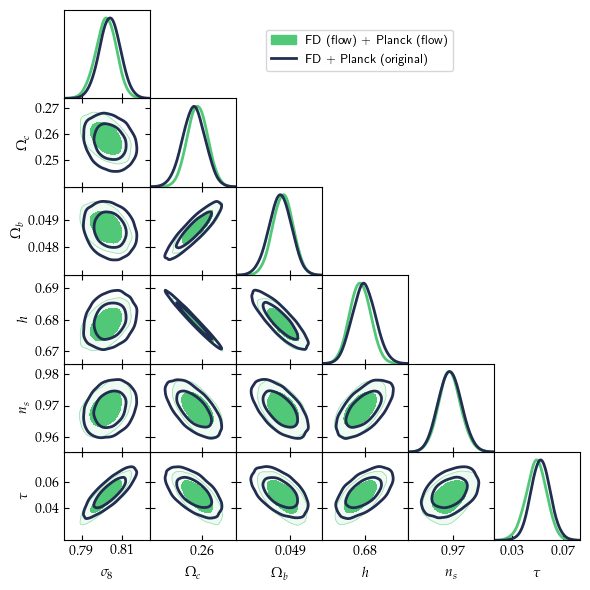

In [54]:
triangle_cosmology(original_samples.values, mcmc_samples_flow, 'FD + Planck (original)', 'FD (flow) + Planck (flow)')

# FD and Planck (flow) - From Carlos

In [96]:
def process_samples_FD_P18_flow(burnin=None, thin=None):
    fname = 'FD_Garcia-Garcia2021_dzMarg_mMarg_P18flowtau0_lcdm_nu' 
    columns = [-6, 3, 4, 5, 6, 7]
    record = []
    record_flow_like = []
    for i in range(4):
        samples = np.loadtxt(f'originalsamples/{fname}/{fname}.{i+1}.txt')
        cosmologies = samples[:,columns]
        flow_like = samples[:,-2]
        if burnin is not None:
            start = int(cosmologies.shape[0] * burnin)
            cosmologies = cosmologies[start:]
            flow_like = flow_like[start:]
        if thin is not None:
            cosmologies = cosmologies[0::thin]
        record.append(cosmologies)
        record_flow_like.append(flow_like)
    record = np.concatenate(record)
    df = pd.DataFrame(record, columns=COLS_tau)
    print(f'Total number of samples for Oxford Full Dataset + Planck (Flow) is: {df.shape[0]}')
    return df, np.concatenate(record_flow_like)

In [97]:
fd_planck_flow, record_flow_like = process_samples_FD_P18_flow(burnin=0.25)

Total number of samples for Oxford Full Dataset + Planck (Flow) is: 5086


In [98]:
np.count_nonzero(record_flow_like)

483

In [99]:
len(record_flow_like)

5086

Removed no burn in
Removed no burn in


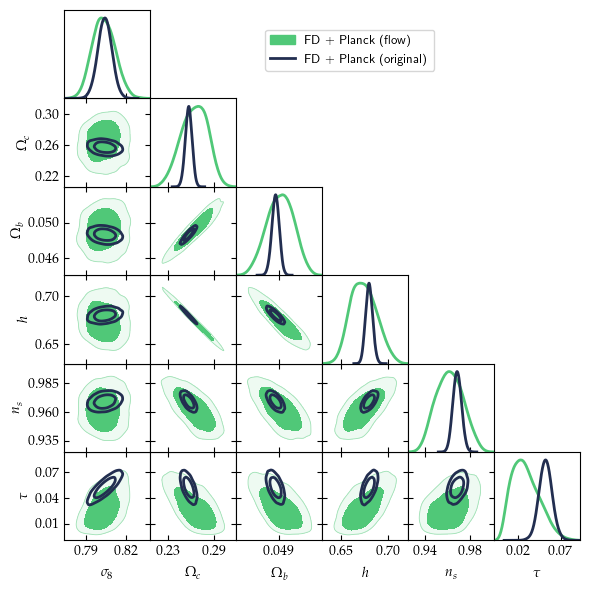

In [100]:
triangle_cosmology(original_samples.values, fd_planck_flow.values, 'FD + Planck (original)', 'FD + Planck (flow)')

In [32]:
def process_samples_P18_flow(burnin=None, thin=None):
    fname = 'P18flow_lcdm_nu' 
    columns = [9, 3, 4, 5, 6, 7]
    record = []
    for i in range(4):
        samples = np.loadtxt(f'originalsamples/{fname}/{fname}.{i+1}.txt')
        cosmologies = samples[:,columns]
        if burnin is not None:
            start = int(cosmologies.shape[0] * burnin)
            cosmologies = cosmologies[start:]
        if thin is not None:
            cosmologies = cosmologies[0::thin]
        record.append(cosmologies)
    record = np.concatenate(record)
    df = pd.DataFrame(record, columns=COLS_tau)
    print(f'Total number of samples for Planck (flow) is: {df.shape[0]}')
    return df

In [33]:
test_flow = process_samples_P18_flow(burnin=0.1)

Total number of samples for Planck (flow) is: 4071


In [34]:
test_flow.head()

,sigma8,Omega_cdm,Omega_b,h,n_s,tau
0,0.808322,0.261654,0.049025,0.676015,0.966118,0.053980
1,0.811756,0.244913,0.047382,0.689677,0.976333,0.070230
2,0.808517,0.258873,0.048978,0.678663,0.968281,0.050782
3,0.808633,0.252390,0.048193,0.683372,0.969110,0.062178
4,0.813280,0.267046,0.049381,0.671318,0.963440,0.054803


Removed no burn in
Removed no burn in


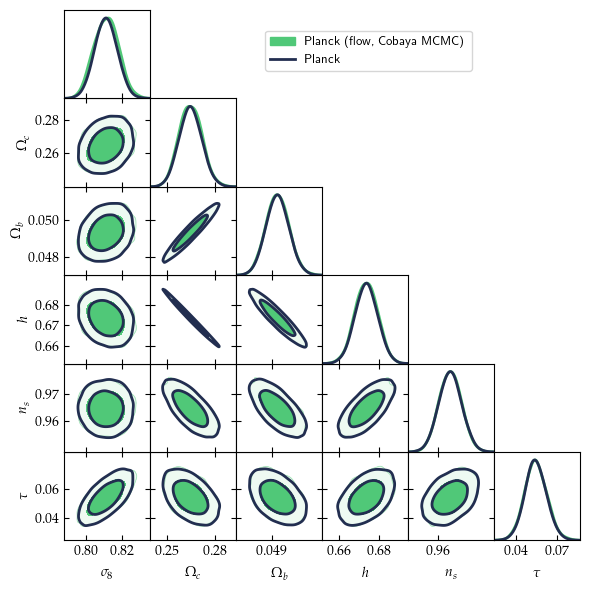

In [35]:
triangle_cosmology(training_points.values, test_flow.values, 'Planck', 'Planck (flow, Cobaya MCMC)')

## Planck Flow with $\tau$ (Joint)

In [ ]:
[22, 3, 4, 5, 6, 7]

In [38]:
def process_samples_FD_P18_flow_tau(burnin=None, thin=None):
    fname = 'FD_Garcia-Garcia2021_dzMarg_mMarg_P18flowtau_lcdm_nu' 
    columns = [22, 3, 4, 5, 6, 7]
    record = []
    record_flow_like = []
    for i in range(4):
        samples = np.loadtxt(f'originalsamples/{fname}/{fname}.{i+1}.txt')
        cosmologies = samples[:,columns]
        flow_like = samples[:,-2]
        if burnin is not None:
            start = int(cosmologies.shape[0] * burnin)
            cosmologies = cosmologies[start:]
            flow_like = flow_like[start:]
        if thin is not None:
            cosmologies = cosmologies[0::thin]
        record.append(cosmologies)
        record_flow_like.append(flow_like)
    record = np.concatenate(record)
    df = pd.DataFrame(record, columns=COLS_tau)
    print(f'Total number of samples for Oxford Full Dataset + Planck (Flow) is: {df.shape[0]}')
    return df, np.concatenate(record_flow_like)

In [39]:
fd_planck_flow = process_samples_FD_P18_flow_tau(burnin=0.1)

Total number of samples for Oxford Full Dataset + Planck (Flow) is: 7138


In [41]:
fd_planck_flow[0].head()

,sigma8,Omega_cdm,Omega_b,h,n_s,tau
0,0.808474,0.253312,0.048143,0.681791,0.968188,0.063430
1,0.806461,0.257134,0.048672,0.679478,0.966702,0.056252
2,0.800917,0.252894,0.048288,0.683134,0.969059,0.052061
3,0.802193,0.257556,0.048812,0.678726,0.965621,0.050876
4,0.802193,0.262612,0.049100,0.674833,0.968902,0.045651


In [46]:
def triangle_cosmology_three(
    samples1: np.ndarray, samples2: np.ndarray, samples3: np.ndarray, 
    label1: str, label2: str, label3: str, fname: str = None
):
    """Creates a triangle plot given the original samples and the flow samples.

    Args:
        samples1 (np.ndarray): the original samples
        samples2 (np.ndarray): the flow samples
        label1 (str): label for the first set of samples
        label2 (str): label for the second set of samples
        fname (str): name of the file for output
    """

    settings = {
        "mult_bias_correction_order": 0,
        "smooth_scale_2D": 0.3,
        "smooth_scale_1D": 0.3,
    }
    color2 = "#50C878"
    color1 = "#222E50"
    color3 = "#3396ff"

    ndim = 6
    names = ["x%s" % i for i in range(ndim)]
    labels = [r"$\sigma_{8}$", r"$\Omega_{c}$", r"$\Omega_{b}$", r"$h$", r"$n_{s}$", r"$\tau$"]

    samples_1 = MCSamples(
        samples=samples1, names=names, labels=labels, label=label1, settings=settings
    )
    samples_2 = MCSamples(
        samples=samples2, names=names, labels=labels, label=label2, settings=settings
    )

    samples_3 = MCSamples(
        samples=samples3, names=names, labels=labels, label=label3, settings=settings
    )

    G = plots.getSubplotPlotter(subplot_size=1.0)
    G.settings.solid_contour_palefactor = 0.9
    G.settings.alpha_filled_add = 0.9
    G.settings.num_plot_contours = 2
    G.settings.lw_contour = 1
    G.settings.axes_fontsize = 15
    G.settings.lab_fontsize = 15
    G.settings.fontsize = 35
    G.settings.legend_fontsize = 14
    samples_1.updateSettings({"contours": [0.68, 0.95]})
    samples_2.updateSettings({"contours": [0.68, 0.95]})
    samples_3.updateSettings({"contours": [0.68, 0.95]})
    G.triangle_plot(
        [samples_2, samples_1, samples_3],
        filled=[True, False],
        contour_colors=[color2, color1, color3],
        contour_lws=[2, 2, 2],
        contour_ls=["-", "-", "-"],
        legend_loc=(0.45, 0.88),
    )
    plt.show()

Removed no burn in
Removed no burn in
Removed no burn in


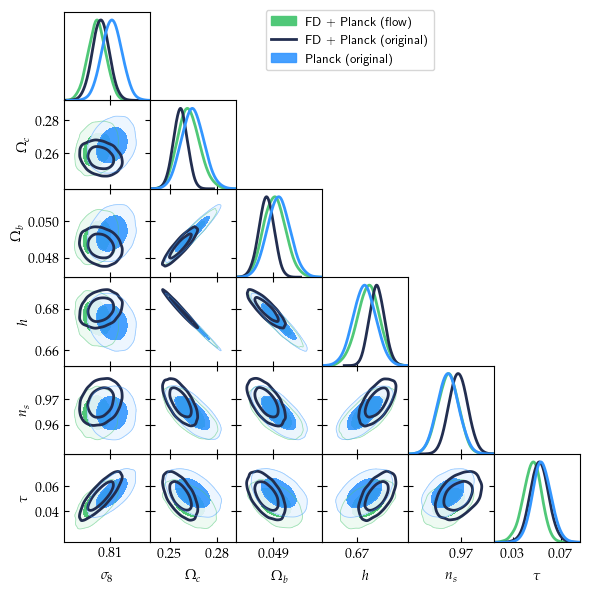

In [47]:
triangle_cosmology_three(original_samples.values, fd_planck_flow[0].values, training_points.values, 
                   'FD + Planck (original)', 'FD + Planck (flow)', 'Planck (original)')

# Camb Testing

In [1]:
import camb
import numpy as np 
import matplotlib.pylab as plt 

# our scripts
from planck.plite import PlanckLitePy
from planck.model import planck_loglike
from cfglib import DESY1PlanckConfig

In [2]:
cfg = DESY1PlanckConfig()

In [3]:
likelihood = PlanckLitePy(
        data_directory=cfg.data,
        year=cfg.year,
        spectra=cfg.spectra,
        use_low_ell_bins=cfg.use_low_ell_bins,
    )

In [4]:
planck_loglike(likelihood, [0.810, 0.25, 0.049, 0.675, 0.965], cfg)

-793.5152162429727